In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import numpy as np
%matplotlib inline
torch.cuda.manual_seed_all(1)
torch.manual_seed(1)
np.random.seed(1)

C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


#### Here is the step-by-step approach, being taken to achieve the required goals (meeting 99.4%+ accuracy, under the required parameters: <=20K and within 20 epochs) :
 
Fix up the required architecture/layer-organization...in terms of choosing the number of kernels for each layer, am trying to follow a 'multiple-of-8' numbers (from 8, 16, 24, 32...etc):

 Architecture will have 3 "components":
 
 1. One initial,"image-conv2d" layer at the begining, to convolve over the "original image" channels, am 
    initially providing 8 number of kernels for this 'separate' layer (which feeds in to the next  
    "2-conv2d-layer-block").It needs to be noted that this 1 initial layer + The 2 following layers(for
    "2-conv2d-layer-block") provide receptive field of 7x7 pixels(3->5->7) sufficient for the MNIST datset's
    edges & gradient generation.In this evolution-experiment, kernel numbers numbers started out as 8 initially, 
    but in the final architecture(which met the requirements) it became 16.
    
	
 2. conv2d-BLOCK with 2 layers (in this case):
    This block will be placed after the first "image-conv2d" layer, and one more instance of this block, will 
    also follow the transition-block (explained below) later.
    In this evolution-experiment, kernel numbers numbers initially started out as (8-16) for the 'first-2-layer-block'
    & (8-16) for the 'second-2-layer-block', but in the final architecture(which met the requirements) it
    became (16-16) for the 'first-2-layer-block' & (24-24) for the 'second-2-layer-block'.
    
    
 3. Transition Blocks:
    1st transition layer, with both max-pool(k=2,s=2) and a-1x1-feature-merger kernel, following the
    'first-2-layer-block'.
    2nd transition layer, towards the end (following the 2nd conv2d-block) which does NOT have
    the maxpool (i.e. just has one 1x1-feature-merger operator), and followed by the Global
    Average Pooling (GAP) layer leading upto the Softmax layer.    
    Here, at the end, we have another 'organization-possibility' i.e. we can also have a GAP layer followed
    by a 1x1 operator (which actually resembles a fully-connected(FC) layer in this case. (Note: for my 
    experiments, am finding that the 1x1, followed by GAP gave BETTER results, as compared to GAP followed
    by 1x1(in a FC-way).
    Hence, will be showing this evolution of incremental changes to 1x1->GAP organization rather than 
    GAP->1x1 (though, the first 2 networks(NW) below show both of them, but later iterations build upon
    the basic-NW having '1x1->GAP' organization only)


### Architecture (i.e. in terms of channels used across individual layers):

    
    i.   "image-conv2d" layer: o/p initially 8 channels (becomes 16 in the final one)
    
    ii.  2 similar conv2d blocks, with:
    
              1st layer: (8-16) o/p channels (becomes (16-16) in the final one)
			 
              2nd layer: (8-16) o/p channels (becomes (24-24) in the final one)
	      
    iii. 1x1 conv2d for 2nd transition-layer: 10 o/p channels(for num-classes=10 digits)
    
 
Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`|      
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7**  
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *8x8* 
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **12x12** 
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **16x16** 
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *16x16*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |


    iv. The 2nd variant could've been, as below, where the last 1x1 is actually behaving like a FC-layer:

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**  
             |          **ReLU**  | 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7**  
             |          **ReLU**  | 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *8x8* 
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **12x12**
             |          **ReLU**  |   
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **16x16** (NO RELU at the o/p of this layer)            
7x7x16               | GAP  LAYER   |      1x16          |  (the output, though can be written as 1x1x16, but is 1-D, i.e.1x16)
*1x1x16*               | *(1x1x16)x10*  |      *1x10*    | (behaves as fully-connected layer for the 1-D data from GAP)


    v. As mentioned earlier, have found better results for the 1x1->GAP option above, rather than GAP->1x1(or, FC)
       hence the increments of Batch Normalization, dropout etc are made with this arrangement.
       
    vi. At the end, following Architecture (same as the first-table above, but with increased number of channels, like below
        is found to achieve the required goal: 14,112 params, >99.4% accuracy, in less than 20 epochs (while 'sticking-to'
        the same learning rate as given in the original code, as Learning-rate tuning is not to be experimented in this session)
        

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x16`   |      `26x26x16`  |      `3x3`
             |          `BN(16)`  |      
             |          `Dropout(3%)`  |      
             |          `ReLU`  |      
**26x26x16**             | **(3x3x16)x16**  |      **24x24x16** |      **5x5** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
**24x24x16**             | **(3x3x16)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x16*  |      *11x11x16*    |      *8x8*   
             |          *BN(16)*  |      
             |          *Dropout(3%)*  |  
             |          *ReLU*  |                 
**11x11x16**             | **(3x3x16)x24**  |      **9x9x24** |      **12x12**  
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |    
             |          **ReLU**  |                 
**9x9x24**               | **(3x3x24)x24**  |      **7x7x24**  |      **16x16**   
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |  
             |          **ReLU**  |                 
*7x7x24*               | *(1x1x24)x10*  |      *7x7x10*    |      *16x16*   (NO RELU at the o/p of this layer)   
7x7x10               | GAP  LAYER   |      1x10          |     

In [11]:
#First NW:

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`|      
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7**  
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *8x8* 
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **12x12** 
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **16x16** 
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *16x16*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

In [3]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:8x8  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:8x8

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:12x12 
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:16x16

        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#input:7x7x16, output:7x7x10, RF:16x16
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))# First Layer Separate
        x = F.relu(self.conv3(F.relu(self.conv2(x))))# First Block
        x = F.relu(self.conv4(self.pool1(x)))# first transition block
        x = F.relu(self.conv6(F.relu(self.conv5(x))))# Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(just 1x1, without a maxpool towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [4]:
#!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model1 = Net1().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
            Conv2d-2            [-1, 8, 24, 24]             576
            Conv2d-3           [-1, 16, 22, 22]           1,152
         MaxPool2d-4           [-1, 16, 11, 11]               0
            Conv2d-5            [-1, 8, 11, 11]             128
            Conv2d-6              [-1, 8, 9, 9]             576
            Conv2d-7             [-1, 16, 7, 7]           1,152
            Conv2d-8             [-1, 10, 7, 7]             160
         AvgPool2d-9             [-1, 10, 1, 1]               0
Total params: 3,816
Trainable params: 3,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.01
Estimated Total Size (MB): 0.19
-----------------------------------------------

In [5]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [7]:
model1 = Net1().to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model1, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model1, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=1.6709644794464111 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:17<00:00, 54.67it/s]



Epoch 1--Train set: Average loss: 1.6710, Training Accuracy: 7682/60000 (12.80%)


Epoch 1--Test set: Average loss: 1.3584, Validation Accuracy: 5432/10000 (54.32%)



epoch=2 loss=0.26218950748443604 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:17<00:00, 53.35it/s]



Epoch 2--Train set: Average loss: 0.2622, Training Accuracy: 51666/60000 (86.11%)


Epoch 2--Test set: Average loss: 0.2932, Validation Accuracy: 9121/10000 (91.21%)



epoch=3 loss=0.1266893744468689 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:17<00:00, 53.54it/s]



Epoch 3--Train set: Average loss: 0.1267, Training Accuracy: 55861/60000 (93.10%)


Epoch 3--Test set: Average loss: 0.2062, Validation Accuracy: 9387/10000 (93.87%)



epoch=4 loss=0.2012055665254593 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:17<00:00, 54.95it/s]



Epoch 4--Train set: Average loss: 0.2012, Training Accuracy: 56824/60000 (94.71%)


Epoch 4--Test set: Average loss: 0.1708, Validation Accuracy: 9473/10000 (94.73%)



epoch=5 loss=0.43567100167274475 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:17<00:00, 54.61it/s]



Epoch 5--Train set: Average loss: 0.4357, Training Accuracy: 57332/60000 (95.55%)


Epoch 5--Test set: Average loss: 0.1153, Validation Accuracy: 9672/10000 (96.72%)



epoch=6 loss=0.32697993516921997 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 52.02it/s]



Epoch 6--Train set: Average loss: 0.3270, Training Accuracy: 57699/60000 (96.17%)


Epoch 6--Test set: Average loss: 0.1210, Validation Accuracy: 9625/10000 (96.25%)



epoch=7 loss=0.009874239563941956 batch_id=937: 100%|████████████████████████████████| 938/938 [00:17<00:00, 52.49it/s]



Epoch 7--Train set: Average loss: 0.0099, Training Accuracy: 57966/60000 (96.61%)


Epoch 7--Test set: Average loss: 0.0977, Validation Accuracy: 9715/10000 (97.15%)



epoch=8 loss=0.03068605065345764 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:17<00:00, 52.38it/s]



Epoch 8--Train set: Average loss: 0.0307, Training Accuracy: 58100/60000 (96.83%)


Epoch 8--Test set: Average loss: 0.0875, Validation Accuracy: 9739/10000 (97.39%)



epoch=9 loss=0.04350864887237549 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 53.38it/s]



Epoch 9--Train set: Average loss: 0.0435, Training Accuracy: 58266/60000 (97.11%)


Epoch 9--Test set: Average loss: 0.0855, Validation Accuracy: 9751/10000 (97.51%)



epoch=10 loss=0.029705137014389038 batch_id=937: 100%|███████████████████████████████| 938/938 [00:17<00:00, 53.00it/s]



Epoch 10--Train set: Average loss: 0.0297, Training Accuracy: 58418/60000 (97.36%)


Epoch 10--Test set: Average loss: 0.0849, Validation Accuracy: 9763/10000 (97.63%)



epoch=11 loss=0.020609110593795776 batch_id=937: 100%|███████████████████████████████| 938/938 [00:17<00:00, 52.28it/s]



Epoch 11--Train set: Average loss: 0.0206, Training Accuracy: 58522/60000 (97.54%)


Epoch 11--Test set: Average loss: 0.0818, Validation Accuracy: 9750/10000 (97.50%)



epoch=12 loss=0.006964683532714844 batch_id=937: 100%|███████████████████████████████| 938/938 [00:17<00:00, 53.18it/s]



Epoch 12--Train set: Average loss: 0.0070, Training Accuracy: 58571/60000 (97.62%)


Epoch 12--Test set: Average loss: 0.0828, Validation Accuracy: 9747/10000 (97.47%)



epoch=13 loss=0.053777456283569336 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 49.67it/s]



Epoch 13--Train set: Average loss: 0.0538, Training Accuracy: 58637/60000 (97.73%)


Epoch 13--Test set: Average loss: 0.0632, Validation Accuracy: 9795/10000 (97.95%)



epoch=14 loss=0.20135977864265442 batch_id=937: 100%|████████████████████████████████| 938/938 [00:17<00:00, 53.65it/s]



Epoch 14--Train set: Average loss: 0.2014, Training Accuracy: 58714/60000 (97.86%)


Epoch 14--Test set: Average loss: 0.0739, Validation Accuracy: 9785/10000 (97.85%)



epoch=15 loss=0.021812111139297485 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 51.23it/s]



Epoch 15--Train set: Average loss: 0.0218, Training Accuracy: 58797/60000 (98.00%)


Epoch 15--Test set: Average loss: 0.0663, Validation Accuracy: 9806/10000 (98.06%)



epoch=16 loss=0.041330814361572266 batch_id=937: 100%|███████████████████████████████| 938/938 [00:17<00:00, 53.65it/s]



Epoch 16--Train set: Average loss: 0.0413, Training Accuracy: 58812/60000 (98.02%)


Epoch 16--Test set: Average loss: 0.0630, Validation Accuracy: 9800/10000 (98.00%)



epoch=17 loss=0.27066728472709656 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 51.60it/s]



Epoch 17--Train set: Average loss: 0.2707, Training Accuracy: 58890/60000 (98.15%)


Epoch 17--Test set: Average loss: 0.0682, Validation Accuracy: 9790/10000 (97.90%)



epoch=18 loss=0.016077309846878052 batch_id=937: 100%|███████████████████████████████| 938/938 [00:17<00:00, 52.81it/s]



Epoch 18--Train set: Average loss: 0.0161, Training Accuracy: 58937/60000 (98.23%)


Epoch 18--Test set: Average loss: 0.0717, Validation Accuracy: 9803/10000 (98.03%)



epoch=19 loss=0.0044090598821640015 batch_id=937: 100%|██████████████████████████████| 938/938 [00:18<00:00, 50.85it/s]



Epoch 19--Train set: Average loss: 0.0044, Training Accuracy: 58924/60000 (98.21%)


Epoch 19--Test set: Average loss: 0.0620, Validation Accuracy: 9825/10000 (98.25%)



epoch=20 loss=0.008360370993614197 batch_id=937: 100%|███████████████████████████████| 938/938 [00:17<00:00, 52.72it/s]



Epoch 20--Train set: Average loss: 0.0084, Training Accuracy: 58975/60000 (98.29%)


Epoch 20--Test set: Average loss: 0.0746, Validation Accuracy: 9786/10000 (97.86%)



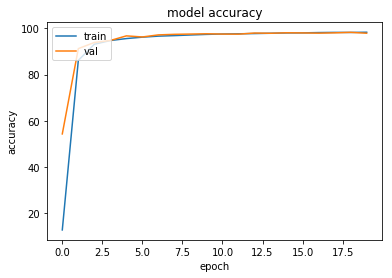

In [8]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

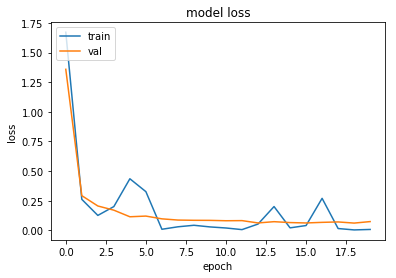

In [9]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- First observation: the parameters are 3,816 the max validation accuracy reached: ~98.25%

- The logs and accuracy plot above show that there is some overfitting in terms of in terms of the accuracy plot, both the train and test accuracies seem to be running in close step.With not much "potential" for the test/validation accuracy to in cerase, with a corresponding increase in training accuracy.

- Additionally, with required 20 epochs, the network capacity seems to be not sufficient to meet the goal.

- But, despite an urgent need for increased channels, we would still like to see, if with added Batch-Norm, Dropout, what effects could be seen? 

- Meantime, we will explore the 2nd variant below as well to see where it stands.

In [12]:
#2nd NW: this is just the GAP->1x1(FC) variant...this variant is not being taken forward for incremental 
#changes (as it was found to be lagging behind as compared to the 1x1->GAP variant discussed earlier)

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**  
             |          **ReLU**  | 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7**  
             |          **ReLU**  | 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *8x8* 
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **12x12**
             |          **ReLU**  |   
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **16x16** (NO RELU at the o/p of this layer)            
7x7x16               | GAP  LAYER   |      1x16          |
*1x1x16*               | *(1x1x16)x10*  |      *1x10*    |  (behaves as fully-connected layer for the 1-D data from GAP)

In [10]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:8x8  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:8x8

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:12x12 
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:16x16
        
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x16, output:1x1x16 (or 1x16, 1-D data format now, with FC allowed at its o/p)
        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#appears to be a conv2d (1x1) kernel, actually is an FC.
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))# First Layer Separate
        x = F.relu(self.conv3(F.relu(self.conv2(x))))# First Block
        x = F.relu(self.conv4(self.pool1(x)))# first transition block
        x = self.conv6(F.relu(self.conv5(x)))# Second Block (there is no ReLU at 2nd Block O/p leading to GAP & beyond)
        x = self.gap1(x) # Global Average Pool layer
        x = self.conv7(x) # Works as a Fully connected layer (on the 1-D data from GAP)
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [11]:
#!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
            Conv2d-2            [-1, 8, 24, 24]             576
            Conv2d-3           [-1, 16, 22, 22]           1,152
         MaxPool2d-4           [-1, 16, 11, 11]               0
            Conv2d-5            [-1, 8, 11, 11]             128
            Conv2d-6              [-1, 8, 9, 9]             576
            Conv2d-7             [-1, 16, 7, 7]           1,152
         AvgPool2d-8             [-1, 16, 1, 1]               0
            Conv2d-9             [-1, 10, 1, 1]             160
Total params: 3,816
Trainable params: 3,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.01
Estimated Total Size (MB): 0.19
-----------------------------------------------

In [12]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [14]:
model2 = Net2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model2, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model2, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=1.2397425174713135 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:14<00:00, 62.55it/s]



Epoch 1--Train set: Average loss: 1.2397, Training Accuracy: 12909/60000 (21.52%)


Epoch 1--Test set: Average loss: 0.7860, Validation Accuracy: 7414/10000 (74.14%)



epoch=2 loss=0.08964434266090393 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:17<00:00, 52.49it/s]



Epoch 2--Train set: Average loss: 0.0896, Training Accuracy: 52566/60000 (87.61%)


Epoch 2--Test set: Average loss: 0.2239, Validation Accuracy: 9335/10000 (93.35%)



epoch=3 loss=0.11771723628044128 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 50.32it/s]



Epoch 3--Train set: Average loss: 0.1177, Training Accuracy: 56537/60000 (94.23%)


Epoch 3--Test set: Average loss: 0.1379, Validation Accuracy: 9546/10000 (95.46%)



epoch=4 loss=0.1862165629863739 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:18<00:00, 51.39it/s]



Epoch 4--Train set: Average loss: 0.1862, Training Accuracy: 57273/60000 (95.45%)


Epoch 4--Test set: Average loss: 0.1125, Validation Accuracy: 9644/10000 (96.44%)



epoch=5 loss=0.1982734650373459 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:18<00:00, 49.80it/s]



Epoch 5--Train set: Average loss: 0.1983, Training Accuracy: 57815/60000 (96.36%)


Epoch 5--Test set: Average loss: 0.1136, Validation Accuracy: 9658/10000 (96.58%)



epoch=6 loss=0.2705570459365845 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:18<00:00, 51.37it/s]



Epoch 6--Train set: Average loss: 0.2706, Training Accuracy: 58003/60000 (96.67%)


Epoch 6--Test set: Average loss: 0.0987, Validation Accuracy: 9691/10000 (96.91%)



epoch=7 loss=0.07064738869667053 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 50.31it/s]



Epoch 7--Train set: Average loss: 0.0706, Training Accuracy: 58212/60000 (97.02%)


Epoch 7--Test set: Average loss: 0.0891, Validation Accuracy: 9721/10000 (97.21%)



epoch=8 loss=0.017079532146453857 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 51.08it/s]



Epoch 8--Train set: Average loss: 0.0171, Training Accuracy: 58302/60000 (97.17%)


Epoch 8--Test set: Average loss: 0.0782, Validation Accuracy: 9743/10000 (97.43%)



epoch=9 loss=0.025124534964561462 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 50.65it/s]



Epoch 9--Train set: Average loss: 0.0251, Training Accuracy: 58392/60000 (97.32%)


Epoch 9--Test set: Average loss: 0.0719, Validation Accuracy: 9775/10000 (97.75%)



epoch=10 loss=0.05337823927402496 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 54.13it/s]



Epoch 10--Train set: Average loss: 0.0534, Training Accuracy: 58547/60000 (97.58%)


Epoch 10--Test set: Average loss: 0.0680, Validation Accuracy: 9790/10000 (97.90%)



epoch=11 loss=0.005270451307296753 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 50.21it/s]



Epoch 11--Train set: Average loss: 0.0053, Training Accuracy: 58547/60000 (97.58%)


Epoch 11--Test set: Average loss: 0.0737, Validation Accuracy: 9770/10000 (97.70%)



epoch=12 loss=0.035432666540145874 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 51.74it/s]



Epoch 12--Train set: Average loss: 0.0354, Training Accuracy: 58633/60000 (97.72%)


Epoch 12--Test set: Average loss: 0.0625, Validation Accuracy: 9793/10000 (97.93%)



epoch=13 loss=0.04815496504306793 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 49.41it/s]



Epoch 13--Train set: Average loss: 0.0482, Training Accuracy: 58675/60000 (97.79%)


Epoch 13--Test set: Average loss: 0.0755, Validation Accuracy: 9749/10000 (97.49%)



epoch=14 loss=0.2519720196723938 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 51.27it/s]



Epoch 14--Train set: Average loss: 0.2520, Training Accuracy: 58742/60000 (97.90%)


Epoch 14--Test set: Average loss: 0.0766, Validation Accuracy: 9772/10000 (97.72%)



epoch=15 loss=0.024411872029304504 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 50.65it/s]



Epoch 15--Train set: Average loss: 0.0244, Training Accuracy: 58762/60000 (97.94%)


Epoch 15--Test set: Average loss: 0.0635, Validation Accuracy: 9796/10000 (97.96%)



epoch=16 loss=0.03120368719100952 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 49.71it/s]



Epoch 16--Train set: Average loss: 0.0312, Training Accuracy: 58825/60000 (98.04%)


Epoch 16--Test set: Average loss: 0.0651, Validation Accuracy: 9795/10000 (97.95%)



epoch=17 loss=0.07456998527050018 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 49.46it/s]



Epoch 17--Train set: Average loss: 0.0746, Training Accuracy: 58840/60000 (98.07%)


Epoch 17--Test set: Average loss: 0.0552, Validation Accuracy: 9826/10000 (98.26%)



epoch=18 loss=0.029345005750656128 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 49.48it/s]



Epoch 18--Train set: Average loss: 0.0293, Training Accuracy: 58829/60000 (98.05%)


Epoch 18--Test set: Average loss: 0.0598, Validation Accuracy: 9826/10000 (98.26%)



epoch=19 loss=0.0071017444133758545 batch_id=937: 100%|██████████████████████████████| 938/938 [00:19<00:00, 49.33it/s]



Epoch 19--Train set: Average loss: 0.0071, Training Accuracy: 58889/60000 (98.15%)


Epoch 19--Test set: Average loss: 0.0658, Validation Accuracy: 9781/10000 (97.81%)



epoch=20 loss=0.0053021907806396484 batch_id=937: 100%|██████████████████████████████| 938/938 [00:19<00:00, 49.25it/s]



Epoch 20--Train set: Average loss: 0.0053, Training Accuracy: 58892/60000 (98.15%)


Epoch 20--Test set: Average loss: 0.0595, Validation Accuracy: 9806/10000 (98.06%)



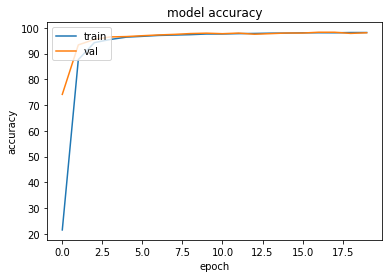

In [15]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

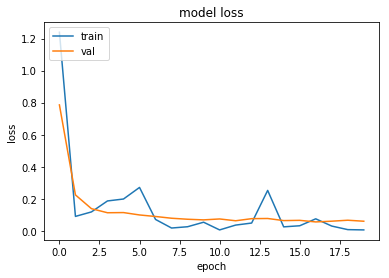

In [16]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- First observation: the parameters are 3,816(same as the 1st variant)

- The other results for this seem to be same at this point, but later on it has been found during the incremental evolution with BN, Dropout etc, the results with this variant weren't comparable to the first (and hence the 1st one itself has been taken thru the next set of changes)


In [14]:
#3rd NW: added Batch Normalization at each layer(we should expect some increase in accuracy in this case)

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`| 
             |          `BN(8)`  |   
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **BN(8)**  |   
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  |  
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *8x8* 
             |          *BN(8)*  |  
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **12x12** 
             |          **BN(8)**  |  
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **16x16** 
             |          **BN(16)**  |  
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *16x16*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

In [4]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:8x8  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:8x8
        self.conv4_bn4 = nn.BatchNorm2d(8)

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:12x12 
        self.conv5_bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:16x16
        self.conv6_bn6 = nn.BatchNorm2d(16)

        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#input:7x7x16, output:7x7x10, RF:16x16
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn1(self.conv1(x)))# First Layer Separate
        x = F.relu(self.conv3_bn3(self.conv3(F.relu(self.conv2_bn2(self.conv2(x))))))# First Block
        x = F.relu(self.conv4_bn4(self.conv4(self.pool1(x))))# first transition block
        x = F.relu(self.conv6_bn6(self.conv6(F.relu(self.conv5_bn5(self.conv5(x))))))# Second Block 
        x = self.conv7(x)#there is no ReLU at this 1x1 operator's O/p, leading to GAP & beyond 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model3 = Net3().to(device)
summary(model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3            [-1, 8, 24, 24]             576
       BatchNorm2d-4            [-1, 8, 24, 24]              16
            Conv2d-5           [-1, 16, 22, 22]           1,152
       BatchNorm2d-6           [-1, 16, 22, 22]              32
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8            [-1, 8, 11, 11]             128
       BatchNorm2d-9            [-1, 8, 11, 11]              16
           Conv2d-10              [-1, 8, 9, 9]             576
      BatchNorm2d-11              [-1, 8, 9, 9]              16
           Conv2d-12             [-1, 16, 7, 7]           1,152
      BatchNorm2d-13             [-1, 16, 7, 7]              32
           Conv2d-14             [-1, 1

In [6]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [8]:
model3 = Net3().to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model3, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model3, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.15882736444473267 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:15<00:00, 62.37it/s]



Epoch 1--Train set: Average loss: 0.1588, Training Accuracy: 50634/60000 (84.39%)


Epoch 1--Test set: Average loss: 0.1680, Validation Accuracy: 9517/10000 (95.17%)



epoch=2 loss=0.10528799891471863 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 51.62it/s]



Epoch 2--Train set: Average loss: 0.1053, Training Accuracy: 58008/60000 (96.68%)


Epoch 2--Test set: Average loss: 0.1391, Validation Accuracy: 9557/10000 (95.57%)



epoch=3 loss=0.08519882708787918 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 52.10it/s]



Epoch 3--Train set: Average loss: 0.0852, Training Accuracy: 58463/60000 (97.44%)


Epoch 3--Test set: Average loss: 0.0705, Validation Accuracy: 9798/10000 (97.98%)



epoch=4 loss=0.11752767115831375 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 50.45it/s]



Epoch 4--Train set: Average loss: 0.1175, Training Accuracy: 58679/60000 (97.80%)


Epoch 4--Test set: Average loss: 0.0732, Validation Accuracy: 9778/10000 (97.78%)



epoch=5 loss=0.42502066493034363 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 50.28it/s]



Epoch 5--Train set: Average loss: 0.4250, Training Accuracy: 58842/60000 (98.07%)


Epoch 5--Test set: Average loss: 0.0574, Validation Accuracy: 9843/10000 (98.43%)



epoch=6 loss=0.1392337530851364 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:18<00:00, 51.24it/s]



Epoch 6--Train set: Average loss: 0.1392, Training Accuracy: 58970/60000 (98.28%)


Epoch 6--Test set: Average loss: 0.0507, Validation Accuracy: 9846/10000 (98.46%)



epoch=7 loss=0.04019387066364288 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 50.01it/s]



Epoch 7--Train set: Average loss: 0.0402, Training Accuracy: 59031/60000 (98.39%)


Epoch 7--Test set: Average loss: 0.0560, Validation Accuracy: 9823/10000 (98.23%)



epoch=8 loss=0.0286845862865448 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:18<00:00, 49.41it/s]



Epoch 8--Train set: Average loss: 0.0287, Training Accuracy: 59069/60000 (98.45%)


Epoch 8--Test set: Average loss: 0.0441, Validation Accuracy: 9866/10000 (98.66%)



epoch=9 loss=0.08036293089389801 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:18<00:00, 53.85it/s]



Epoch 9--Train set: Average loss: 0.0804, Training Accuracy: 59114/60000 (98.52%)


Epoch 9--Test set: Average loss: 0.0412, Validation Accuracy: 9889/10000 (98.89%)



epoch=10 loss=0.01831786334514618 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 49.95it/s]



Epoch 10--Train set: Average loss: 0.0183, Training Accuracy: 59232/60000 (98.72%)


Epoch 10--Test set: Average loss: 0.0498, Validation Accuracy: 9851/10000 (98.51%)



epoch=11 loss=0.007248088717460632 batch_id=937: 100%|███████████████████████████████| 938/938 [00:19<00:00, 49.05it/s]



Epoch 11--Train set: Average loss: 0.0072, Training Accuracy: 59234/60000 (98.72%)


Epoch 11--Test set: Average loss: 0.0400, Validation Accuracy: 9883/10000 (98.83%)



epoch=12 loss=0.006146252155303955 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 54.76it/s]



Epoch 12--Train set: Average loss: 0.0061, Training Accuracy: 59303/60000 (98.84%)


Epoch 12--Test set: Average loss: 0.0426, Validation Accuracy: 9863/10000 (98.63%)



epoch=13 loss=0.03886513411998749 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 50.03it/s]



Epoch 13--Train set: Average loss: 0.0389, Training Accuracy: 59321/60000 (98.87%)


Epoch 13--Test set: Average loss: 0.0368, Validation Accuracy: 9882/10000 (98.82%)



epoch=14 loss=0.1306706666946411 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:19<00:00, 48.08it/s]



Epoch 14--Train set: Average loss: 0.1307, Training Accuracy: 59332/60000 (98.89%)


Epoch 14--Test set: Average loss: 0.0375, Validation Accuracy: 9879/10000 (98.79%)



epoch=15 loss=0.013973340392112732 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 50.08it/s]



Epoch 15--Train set: Average loss: 0.0140, Training Accuracy: 59344/60000 (98.91%)


Epoch 15--Test set: Average loss: 0.0343, Validation Accuracy: 9894/10000 (98.94%)



epoch=16 loss=0.010487392544746399 batch_id=937: 100%|███████████████████████████████| 938/938 [00:19<00:00, 48.71it/s]



Epoch 16--Train set: Average loss: 0.0105, Training Accuracy: 59369/60000 (98.95%)


Epoch 16--Test set: Average loss: 0.0383, Validation Accuracy: 9878/10000 (98.78%)



epoch=17 loss=0.16186638176441193 batch_id=937: 100%|████████████████████████████████| 938/938 [00:18<00:00, 55.18it/s]



Epoch 17--Train set: Average loss: 0.1619, Training Accuracy: 59400/60000 (99.00%)


Epoch 17--Test set: Average loss: 0.0383, Validation Accuracy: 9889/10000 (98.89%)



epoch=18 loss=0.060642242431640625 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 49.89it/s]



Epoch 18--Train set: Average loss: 0.0606, Training Accuracy: 59400/60000 (99.00%)


Epoch 18--Test set: Average loss: 0.0361, Validation Accuracy: 9881/10000 (98.81%)



epoch=19 loss=0.0007540583610534668 batch_id=937: 100%|██████████████████████████████| 938/938 [00:19<00:00, 48.94it/s]



Epoch 19--Train set: Average loss: 0.0008, Training Accuracy: 59451/60000 (99.08%)


Epoch 19--Test set: Average loss: 0.0404, Validation Accuracy: 9878/10000 (98.78%)



epoch=20 loss=0.012153729796409607 batch_id=937: 100%|███████████████████████████████| 938/938 [00:18<00:00, 50.29it/s]



Epoch 20--Train set: Average loss: 0.0122, Training Accuracy: 59410/60000 (99.02%)


Epoch 20--Test set: Average loss: 0.0394, Validation Accuracy: 9874/10000 (98.74%)



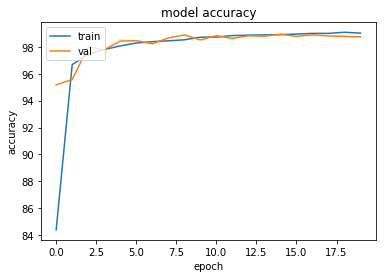

In [9]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

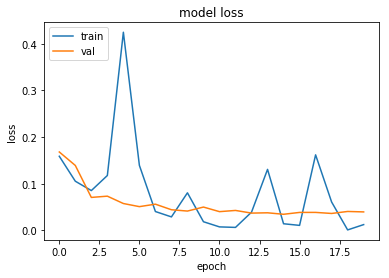

In [10]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- Total params: 3,944 (which is expectedly, higher as compared to the 1st NW) & the max validation accuracy reaches: ~98.94%
- we got little better in terms of the reached accuracy  but expectedly, far from the required accuracy goal.
- Also in terms of the accuracy plot & logs, we could see that the further potential for increase for the validation accuracy has not yet opened up (it is overfitting...i.e. the training accuracy has reached 99.08% but the validation acuracy still under ~98.8%, hence not much scope for further increase with a corresponding increase in training accuracy )
- just like the earlier NWs, this one can't meet the goal within the required 20 epochs(capacity boost required)

In [12]:
#4th NW: added Dropout as well at each layer apart from the BN(we should expect lesser overfitting 
# i.e an increase in the "potential" to increase validation accuracy with corresponding increase in training-accuracy)
# i.e. a gap opens up
# The value for 3% for Dropout was giving a better results as compared to other test-ranges from 1-10%

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x8`   |      `26x26x8`  |      `3x3`| 
             |          `BN(8)`  | 
             |          `Dropout(3%)`  |                
             |          `ReLU`  | 
**26x26x8**             | **(3x3x8)x8**  |      **24x24x8** |      **5x5**
             |          **BN(8)**  | 
             |          **Dropout(3%)** |                
             |          **ReLU**  |                 
**24x24x8**             | **(3x3x8)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  | 
             |          **Dropout(3%)** |              
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x8*  |      *11x11x8*    |      *8x8* 
             |          *BN(8)*  |  
             |          *Dropout(3%)* |              
             |          *ReLU*  |     
**11x11x8**             | **(3x3x8)x8**  |      **9x9x8** |      **12x12** 
             |          **BN(8)**  | 
             |          **Dropout(3%)** |             
             |          **ReLU**  |       
**9x9x8**               | **(3x3x8)x16**  |      **7x7x16**  |      **16x16** 
             |          **BN(16)**  |  
             |          **Dropout(3%)** |             
             |          **ReLU**  |       
*7x7x16*               | *(1x1x16)x10*  |      *7x7x10*    |      *16x16*  (NO RELU at the o/p of this layer)    
7x7x10               | GAP  LAYER   |      1x10          |

In [4]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)#input:28x28x1, output:26x26x8, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(8)
        self.conv1_drop1 = nn.Dropout2d(0.03)

        self.conv2 = nn.Conv2d(8, 8, 3, bias=False)#input:26x26x8, output:24x24x8, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(8)
        self.conv2_drop2 = nn.Dropout2d(0.03)
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False)#input:24x24x8, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)
        self.conv3_drop3 = nn.Dropout2d(0.03)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:8x8  
        self.conv4 = nn.Conv2d(16, 8, 1, bias=False)#input:11x11x16, output:11x11x8, RF:8x8
        self.conv4_bn4 = nn.BatchNorm2d(8)
        self.conv4_drop4 = nn.Dropout2d(0.03)

        self.conv5 = nn.Conv2d(8, 8, 3, bias=False)#input:11x11x8, output:9x9x8, RF:12x12 
        self.conv5_bn5 = nn.BatchNorm2d(8)
        self.conv5_drop5 = nn.Dropout2d(0.03)
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)#input:9x9x8, output:7x7x16, RF:16x16
        self.conv6_bn6 = nn.BatchNorm2d(16)
        self.conv6_drop6 = nn.Dropout2d(0.03)

        self.conv7 = nn.Conv2d(16, 10, 1, bias=False)#input:7x7x16, output:7x7x10, RF:16x16
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_drop1(self.conv1_bn1(self.conv1(x))))# First Layer Separate
        x = F.relu(self.conv3_drop3(self.conv3_bn3(self.conv3(F.relu(self.conv2_drop2(self.conv2_bn2(self.conv2(x))))))))# First Block
        x = F.relu(self.conv4_drop4(self.conv4_bn4(self.conv4(self.pool1(x)))))# first transition block
        x = F.relu(self.conv6_drop6(self.conv6_bn6(self.conv6(F.relu(self.conv5_drop5(self.conv5_bn5(self.conv5(x))))))))# Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(without a maxpool towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model4 = Net4().to(device)
summary(model4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
         Dropout2d-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
         Dropout2d-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,152
       BatchNorm2d-8           [-1, 16, 22, 22]              32
         Dropout2d-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11            [-1, 8, 11, 11]             128
      BatchNorm2d-12            [-1, 8, 11, 11]              16
        Dropout2d-13            [-1, 8, 11, 11]               0
           Conv2d-14              [-1, 

In [6]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [7]:
model4 = Net4().to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model4, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model4, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.5693467259407043 batch_id=468: 100%|██████████████████████████████████| 469/469 [00:14<00:00, 34.78it/s]



Epoch 1--Train set: Average loss: 0.5693, Training Accuracy: 36677/60000 (61.13%)


Epoch 1--Test set: Average loss: 0.3870, Validation Accuracy: 9366/10000 (93.66%)



epoch=2 loss=0.316652774810791 batch_id=468: 100%|███████████████████████████████████| 469/469 [00:16<00:00, 26.93it/s]



Epoch 2--Train set: Average loss: 0.3167, Training Accuracy: 52933/60000 (88.22%)


Epoch 2--Test set: Average loss: 0.1754, Validation Accuracy: 9624/10000 (96.24%)



epoch=3 loss=0.22723042964935303 batch_id=468: 100%|█████████████████████████████████| 469/469 [00:16<00:00, 27.76it/s]



Epoch 3--Train set: Average loss: 0.2272, Training Accuracy: 54858/60000 (91.43%)


Epoch 3--Test set: Average loss: 0.1281, Validation Accuracy: 9704/10000 (97.04%)



epoch=4 loss=0.23588551580905914 batch_id=468: 100%|█████████████████████████████████| 469/469 [00:16<00:00, 27.90it/s]



Epoch 4--Train set: Average loss: 0.2359, Training Accuracy: 55649/60000 (92.75%)


Epoch 4--Test set: Average loss: 0.1003, Validation Accuracy: 9710/10000 (97.10%)



epoch=5 loss=0.198771670460701 batch_id=468: 100%|███████████████████████████████████| 469/469 [00:17<00:00, 26.55it/s]



Epoch 5--Train set: Average loss: 0.1988, Training Accuracy: 56165/60000 (93.61%)


Epoch 5--Test set: Average loss: 0.0907, Validation Accuracy: 9763/10000 (97.63%)



epoch=6 loss=0.1972697228193283 batch_id=468: 100%|██████████████████████████████████| 469/469 [00:17<00:00, 28.41it/s]



Epoch 6--Train set: Average loss: 0.1973, Training Accuracy: 56354/60000 (93.92%)


Epoch 6--Test set: Average loss: 0.0804, Validation Accuracy: 9762/10000 (97.62%)



epoch=7 loss=0.18749789893627167 batch_id=468: 100%|█████████████████████████████████| 469/469 [00:17<00:00, 27.46it/s]



Epoch 7--Train set: Average loss: 0.1875, Training Accuracy: 56579/60000 (94.30%)


Epoch 7--Test set: Average loss: 0.0732, Validation Accuracy: 9790/10000 (97.90%)



epoch=8 loss=0.17562086880207062 batch_id=468: 100%|█████████████████████████████████| 469/469 [00:17<00:00, 27.20it/s]



Epoch 8--Train set: Average loss: 0.1756, Training Accuracy: 56801/60000 (94.67%)


Epoch 8--Test set: Average loss: 0.0715, Validation Accuracy: 9806/10000 (98.06%)



epoch=9 loss=0.14125289022922516 batch_id=468: 100%|█████████████████████████████████| 469/469 [00:17<00:00, 27.41it/s]



Epoch 9--Train set: Average loss: 0.1413, Training Accuracy: 56888/60000 (94.81%)


Epoch 9--Test set: Average loss: 0.0665, Validation Accuracy: 9804/10000 (98.04%)



epoch=10 loss=0.10024780035018921 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 26.38it/s]



Epoch 10--Train set: Average loss: 0.1002, Training Accuracy: 57015/60000 (95.03%)


Epoch 10--Test set: Average loss: 0.0655, Validation Accuracy: 9810/10000 (98.10%)



epoch=11 loss=0.08846772462129593 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 27.67it/s]



Epoch 11--Train set: Average loss: 0.0885, Training Accuracy: 57074/60000 (95.12%)


Epoch 11--Test set: Average loss: 0.0642, Validation Accuracy: 9805/10000 (98.05%)



epoch=12 loss=0.12440105527639389 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 28.18it/s]



Epoch 12--Train set: Average loss: 0.1244, Training Accuracy: 57255/60000 (95.42%)


Epoch 12--Test set: Average loss: 0.0592, Validation Accuracy: 9828/10000 (98.28%)



epoch=13 loss=0.12033355981111526 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 27.49it/s]



Epoch 13--Train set: Average loss: 0.1203, Training Accuracy: 57284/60000 (95.47%)


Epoch 13--Test set: Average loss: 0.0559, Validation Accuracy: 9822/10000 (98.22%)



epoch=14 loss=0.1474582403898239 batch_id=468: 100%|█████████████████████████████████| 469/469 [00:17<00:00, 27.38it/s]



Epoch 14--Train set: Average loss: 0.1475, Training Accuracy: 57325/60000 (95.54%)


Epoch 14--Test set: Average loss: 0.0590, Validation Accuracy: 9819/10000 (98.19%)



epoch=15 loss=0.14605693519115448 batch_id=468: 100%|████████████████████████████████| 469/469 [00:18<00:00, 25.91it/s]



Epoch 15--Train set: Average loss: 0.1461, Training Accuracy: 57390/60000 (95.65%)


Epoch 15--Test set: Average loss: 0.0555, Validation Accuracy: 9833/10000 (98.33%)



epoch=16 loss=0.14972145855426788 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 26.28it/s]



Epoch 16--Train set: Average loss: 0.1497, Training Accuracy: 57489/60000 (95.81%)


Epoch 16--Test set: Average loss: 0.0553, Validation Accuracy: 9840/10000 (98.40%)



epoch=17 loss=0.17868442833423615 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 27.09it/s]



Epoch 17--Train set: Average loss: 0.1787, Training Accuracy: 57528/60000 (95.88%)


Epoch 17--Test set: Average loss: 0.0542, Validation Accuracy: 9836/10000 (98.36%)



epoch=18 loss=0.12796051800251007 batch_id=468: 100%|████████████████████████████████| 469/469 [00:18<00:00, 27.24it/s]



Epoch 18--Train set: Average loss: 0.1280, Training Accuracy: 57546/60000 (95.91%)


Epoch 18--Test set: Average loss: 0.0536, Validation Accuracy: 9829/10000 (98.29%)



epoch=19 loss=0.09476268291473389 batch_id=468: 100%|████████████████████████████████| 469/469 [00:18<00:00, 26.01it/s]



Epoch 19--Train set: Average loss: 0.0948, Training Accuracy: 57632/60000 (96.05%)


Epoch 19--Test set: Average loss: 0.0535, Validation Accuracy: 9837/10000 (98.37%)



epoch=20 loss=0.10934152454137802 batch_id=468: 100%|████████████████████████████████| 469/469 [00:17<00:00, 27.40it/s]



Epoch 20--Train set: Average loss: 0.1093, Training Accuracy: 57641/60000 (96.07%)


Epoch 20--Test set: Average loss: 0.0521, Validation Accuracy: 9841/10000 (98.41%)



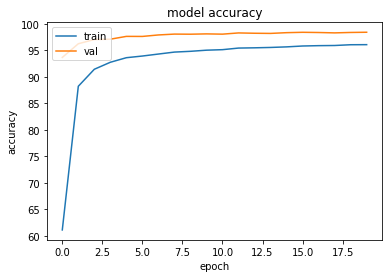

In [8]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

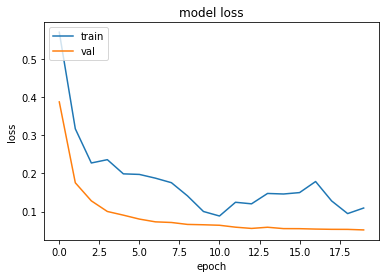

In [9]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- Total params: 3,944 (which is expectedly,same as compared to the last NW as dropout doesn't add params) & the max validation accuracy reaches: ~98.4% (though this seems almost comparable to the achieved max in last iteration, but in case of adding Dropout, we have overcome the overfitting issue, by opening up the gap between training and test accuracies...i.e. now we can see that the test accuracy value like ~98% is achieved while the training accuracy is still at ~96%, which has opened up the potential for further increase in the validation accuracy, given we have a required number of epochs and NW-capacity with us.

- Also in terms of the accuracy plot, both the train and test accuracies seem to be maintaining almost consistent gap (training accuracy growth is looking stagnant though, but some scope is open)
- As a final step for this architecture-option we are required to the given Learning rate value hence that aspect won't be explored further.
- But to achieve the required goal we will have to go for a capacity increase now, the next iteration tries to do the same.

In [10]:
#5th NW: while retaining the same template for the Batch Normalization, Dropout and layering, we now increase the channels
# to follow the layering as given below.
# The value for 3% for Dropout was giving a better results as compared to other test-ranges from 1-10%
# "|16|--|16-16|--|Transition|--|24-24|--|Transition|--|GAP|--|softmax-classifier|" as in the table below

Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|----------------------
`28x28x1`              | `(3x3x1)x16`   |      `26x26x16`  |      `3x3`
             |          `BN(16)`  |      
             |          `Dropout(3%)`  |      
             |          `ReLU`  |      
**26x26x16**             | **(3x3x16)x16**  |      **24x24x16** |      **5x5** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
**24x24x16**             | **(3x3x16)x16**  |      **22x22x16** |      **7x7** 
             |          **BN(16)**  |      
             |          **Dropout(3%)**  |   
             |          **ReLU**  |                 
*22x22x16*             |   *MP(2x2)*    |      *11x11x16*   |      *8x8*                      
*11x11x16*             | *(1x1x16)x16*  |      *11x11x16*    |      *8x8*   
             |          *BN(16)*  |      
             |          *Dropout(3%)*  |  
             |          *ReLU*  |                 
**11x11x16**             | **(3x3x16)x24**  |      **9x9x24** |      **12x12**  
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |    
             |          **ReLU**  |                 
**9x9x24**               | **(3x3x24)x24**  |      **7x7x24**  |      **16x16**   
             |          **BN(24)**  |      
             |          **Dropout(3%)**  |  
             |          **ReLU**  |                 
*7x7x24*               | *(1x1x24)x10*  |      *7x7x10*    |      *16x16*  (NO RELU at the o/p of this layer)     
7x7x10               | GAP  LAYER   |      1x10          |     

In [10]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, bias=False)#input:28x28x1, output:26x26x16, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(16)
        self.conv1_drop1 = nn.Dropout2d(0.03)

        self.conv2 = nn.Conv2d(16, 16, 3, bias=False)#input:26x26x16, output:24x24x16, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(16)
        self.conv2_drop2 = nn.Dropout2d(0.03)
        self.conv3 = nn.Conv2d(16, 16, 3, bias=False)#input:24x24x16, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)
        self.conv3_drop3 = nn.Dropout2d(0.03)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:8x8  
        self.conv4 = nn.Conv2d(16, 16, 1, bias=False)#input:11x11x16, output:11x11x16, RF:8x8
        self.conv4_bn4 = nn.BatchNorm2d(16)
        self.conv4_drop4 = nn.Dropout2d(0.03)

        self.conv5 = nn.Conv2d(16, 24, 3, bias=False)#input:11x11x16, output:9x9x24, RF:12x12 
        self.conv5_bn5 = nn.BatchNorm2d(24)
        self.conv5_drop5 = nn.Dropout2d(0.03)
        self.conv6 = nn.Conv2d(24, 24, 3, bias=False)#input:9x9x24, output:7x7x24, RF:16x16
        self.conv6_bn6 = nn.BatchNorm2d(24)
        self.conv6_drop6 = nn.Dropout2d(0.03)
        
        self.conv7 = nn.Conv2d(24, 10, 1, bias=False)#input:7x7x24, output:7x7x10, RF:16x16
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_drop1(self.conv1_bn1(self.conv1(x))))#First Layer Separate
        x = F.relu(self.conv3_drop3(self.conv3_bn3(self.conv3(F.relu(self.conv2_drop2(self.conv2_bn2(self.conv2(x))))))))#First Block
        x = F.relu(self.conv4_drop4(self.conv4_bn4(self.conv4(self.pool1(x)))))#First transition block
        x = F.relu(self.conv6_drop6(self.conv6_bn6(self.conv6(F.relu(self.conv5_drop5(self.conv5_bn5(self.conv5(x))))))))#Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(without a maxpool towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model5 = Net5().to(device)
summary(model5, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,304
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,304
       BatchNorm2d-8           [-1, 16, 22, 22]              32
         Dropout2d-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             256
      BatchNorm2d-12           [-1, 16, 11, 11]              32
        Dropout2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 2

In [12]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [13]:
model5 = Net5().to(device)
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model5, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model5, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.24695727229118347 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:17<00:00, 53.41it/s]



Epoch 1--Train set: Average loss: 0.2470, Training Accuracy: 50740/60000 (84.57%)


Epoch 1--Test set: Average loss: 0.0878, Validation Accuracy: 9805/10000 (98.05%)



epoch=2 loss=0.10117413103580475 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:20<00:00, 44.78it/s]



Epoch 2--Train set: Average loss: 0.1012, Training Accuracy: 57848/60000 (96.41%)


Epoch 2--Test set: Average loss: 0.0527, Validation Accuracy: 9857/10000 (98.57%)



epoch=3 loss=0.05008406937122345 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:20<00:00, 46.56it/s]



Epoch 3--Train set: Average loss: 0.0501, Training Accuracy: 58466/60000 (97.44%)


Epoch 3--Test set: Average loss: 0.0373, Validation Accuracy: 9890/10000 (98.90%)



epoch=4 loss=0.0396733433008194 batch_id=937: 100%|██████████████████████████████████| 938/938 [00:21<00:00, 44.29it/s]



Epoch 4--Train set: Average loss: 0.0397, Training Accuracy: 58661/60000 (97.77%)


Epoch 4--Test set: Average loss: 0.0331, Validation Accuracy: 9902/10000 (99.02%)



epoch=5 loss=0.009025141596794128 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 44.38it/s]



Epoch 5--Train set: Average loss: 0.0090, Training Accuracy: 58782/60000 (97.97%)


Epoch 5--Test set: Average loss: 0.0305, Validation Accuracy: 9905/10000 (99.05%)



epoch=6 loss=0.04769548773765564 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:21<00:00, 43.98it/s]



Epoch 6--Train set: Average loss: 0.0477, Training Accuracy: 58883/60000 (98.14%)


Epoch 6--Test set: Average loss: 0.0275, Validation Accuracy: 9914/10000 (99.14%)



epoch=7 loss=0.033467262983322144 batch_id=937: 100%|████████████████████████████████| 938/938 [00:20<00:00, 45.82it/s]



Epoch 7--Train set: Average loss: 0.0335, Training Accuracy: 58990/60000 (98.32%)


Epoch 7--Test set: Average loss: 0.0253, Validation Accuracy: 9923/10000 (99.23%)



epoch=8 loss=0.06352145969867706 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:21<00:00, 42.98it/s]



Epoch 8--Train set: Average loss: 0.0635, Training Accuracy: 58975/60000 (98.29%)


Epoch 8--Test set: Average loss: 0.0253, Validation Accuracy: 9917/10000 (99.17%)



epoch=9 loss=0.09636054933071136 batch_id=937: 100%|█████████████████████████████████| 938/938 [00:20<00:00, 44.70it/s]



Epoch 9--Train set: Average loss: 0.0964, Training Accuracy: 59030/60000 (98.38%)


Epoch 9--Test set: Average loss: 0.0223, Validation Accuracy: 9931/10000 (99.31%)



epoch=10 loss=0.01684170961380005 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 42.92it/s]



Epoch 10--Train set: Average loss: 0.0168, Training Accuracy: 59097/60000 (98.50%)


Epoch 10--Test set: Average loss: 0.0214, Validation Accuracy: 9933/10000 (99.33%)



epoch=11 loss=0.06998667120933533 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 44.58it/s]



Epoch 11--Train set: Average loss: 0.0700, Training Accuracy: 59086/60000 (98.48%)


Epoch 11--Test set: Average loss: 0.0227, Validation Accuracy: 9930/10000 (99.30%)



epoch=12 loss=0.24019618332386017 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 43.02it/s]



Epoch 12--Train set: Average loss: 0.2402, Training Accuracy: 59111/60000 (98.52%)


Epoch 12--Test set: Average loss: 0.0205, Validation Accuracy: 9943/10000 (99.43%)



epoch=13 loss=0.17071953415870667 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 43.51it/s]



Epoch 13--Train set: Average loss: 0.1707, Training Accuracy: 59157/60000 (98.59%)


Epoch 13--Test set: Average loss: 0.0189, Validation Accuracy: 9949/10000 (99.49%)



epoch=14 loss=0.041865766048431396 batch_id=937: 100%|███████████████████████████████| 938/938 [00:21<00:00, 44.55it/s]



Epoch 14--Train set: Average loss: 0.0419, Training Accuracy: 59237/60000 (98.73%)


Epoch 14--Test set: Average loss: 0.0224, Validation Accuracy: 9923/10000 (99.23%)



epoch=15 loss=0.036569446325302124 batch_id=937: 100%|███████████████████████████████| 938/938 [00:21<00:00, 43.28it/s]



Epoch 15--Train set: Average loss: 0.0366, Training Accuracy: 59190/60000 (98.65%)


Epoch 15--Test set: Average loss: 0.0196, Validation Accuracy: 9940/10000 (99.40%)



epoch=16 loss=0.04074643552303314 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 43.41it/s]



Epoch 16--Train set: Average loss: 0.0407, Training Accuracy: 59251/60000 (98.75%)


Epoch 16--Test set: Average loss: 0.0198, Validation Accuracy: 9944/10000 (99.44%)



epoch=17 loss=0.011231973767280579 batch_id=937: 100%|███████████████████████████████| 938/938 [00:21<00:00, 43.52it/s]



Epoch 17--Train set: Average loss: 0.0112, Training Accuracy: 59259/60000 (98.77%)


Epoch 17--Test set: Average loss: 0.0189, Validation Accuracy: 9942/10000 (99.42%)



epoch=18 loss=0.008846849203109741 batch_id=937: 100%|███████████████████████████████| 938/938 [00:21<00:00, 44.03it/s]



Epoch 18--Train set: Average loss: 0.0088, Training Accuracy: 59313/60000 (98.86%)


Epoch 18--Test set: Average loss: 0.0178, Validation Accuracy: 9947/10000 (99.47%)



epoch=19 loss=0.04289734363555908 batch_id=937: 100%|████████████████████████████████| 938/938 [00:21<00:00, 42.78it/s]



Epoch 19--Train set: Average loss: 0.0429, Training Accuracy: 59279/60000 (98.80%)


Epoch 19--Test set: Average loss: 0.0195, Validation Accuracy: 9937/10000 (99.37%)



epoch=20 loss=0.001962423324584961 batch_id=937: 100%|███████████████████████████████| 938/938 [00:21<00:00, 42.83it/s]



Epoch 20--Train set: Average loss: 0.0020, Training Accuracy: 59311/60000 (98.85%)


Epoch 20--Test set: Average loss: 0.0167, Validation Accuracy: 9954/10000 (99.54%)



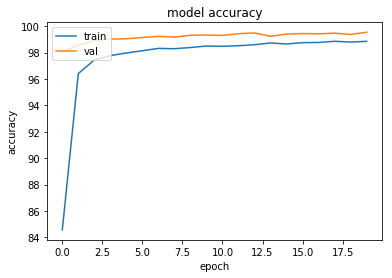

In [14]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

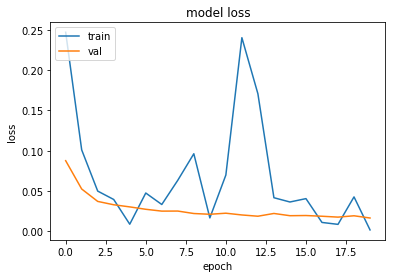

In [15]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

- Total params:  14,112 (which is expected,given higher NW capacity) & the max validation accuracy reaches: ~99.54% 

- This case meets the required goal of getting an accuracy of 99.4% (appeared 5 times during training-epochs), the parameters: 14,112 < 20K (requirement) and came under 20 epochs.